# Fitting rate parameterfor CsgA inhibitor

In this notebook, we will derive a numerical model for the CsgA inhibitor QFGGGNPP (QFG) based on an article by <a href="https://www.sciencedirect.com/science/article/pii/S0022283605008168"> I. Cherny<i>et. al.</i></a>. In the article, <i>E.Coli</i> is grown in 300 $\mu$M QFG for 5-7 h. A 30 % decrease in Curli polymerisation was observed through a fluorescence assay. The bacteria concentration in the experiment was approximately $10^9 \frac{bacteria}{dm^3}$ ($OD_{600}=1.2$). 

In the paper, QFG is descibed to bind 1 to 1 with CsgA monomers. We therefore assume the following equilibrium:
$$CsgA + QFG \rightleftharpoons CsgA-QFG$$
This gives us the rate equation for QFG:
$$\frac{d[QFG]}{dt} = k_d [CsgA-QFG] - k_a [CsgA][QFG]$$
and, extending on the rate equations for CsgA described in [link to notebook]:
$$\frac{d[CsgA]}{dt} = pA - k_+[Curli][CsgA] + k_d [CsgA-QFG] - k_a [CsgA][QFG]$$
where $pA$ and $k_+$ are the production rate of CsgA and the elongation rate of Curli, $k_d$ is the disassociation costant for CsgA-QFG and $k_a$ is the association constant. We can, for simplicity, assume that the disassociation is small. Also, since the inhibitor concentration is much greater than the Curli concentration, we can assume a constant QFG concentration. We are then left to estimate the association constant $k_a$.

We have implemented a more flexible, and object oriented, version of the model described in [link to notebook].

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Math, Latex
from fibrilformation import UniformFibrilFormation, CurliFibril
print('Documentation UniformFibrilFormation')
print(UniformFibrilFormation.__doc__)
print('UniformFibrilFormation __init__ function')
print(UniformFibrilFormation.__init__.__doc__)
print(CurliFibril.__doc__)

Documentation UniformFibrilFormation

    Simulates Curli fibril formation given environment and inhibitors.

    ...

    Attributes
    ----------
    dist: float
        total simulated distance from bacteria cell membrane
    CSGBRATE: constant 1.3e-13
        production rate of CsgB protein (nbr/bacteria/s)
    xsteps: int
        number of bins to keep track of fibrils in
    deltat: float
        length of one timestep
    deltax: float
        length of one bin
    cBacteria: float
        bacteria concentration

    Methods
    ----------
    timeStep:
        Steps time forward one timestep
        Args:
            None
        Returns:
            None
    getTime:
        Returns the total time simulated this far
        Args:
            None
        Returns:
            total time (float)
    getMass:
        Returns the total mass of Curli fibrils (/CsgA mass)
        Args:
            None
        Returns:
            total mass (int)
    getMassProfile:
        Return

Using the class UniformFibrilFormation, it is easy to supply an inhibitor. When we define it, we let the rate constant $k_a$ be an argument to the class, giving us the ability to later fit it. 

In [2]:
class QFGStatic(object):
    C = 3e-4 #Fixed concentration
    def __init__(self, deltat, KA):
        """
        To simulate the rate equation, we need to know the length of one timestep, as well as the rate constant k_a.
        """
        self.KA = KA
        self.deltat = deltat
    
    def timeStep(self, other):
        """
        Here, other is an object containing the CsgA concentration (among other things). We can easily change it inplace by
        accessing the 'c' attribute. 
        """
        other.c -= max(self.KA*self.C*other.c*self.deltat, 0)
    def rateFunc(self,other, kwrates):
        """
        This function is required for all inhibitor objects because of lazy programming. 
        """
        return kwrates

Defining parameters and constants:

In [3]:
MAX_DISTANCE = 2e-5 #m
N_XSTEPS = 500
x_step_length = MAX_DISTANCE / N_XSTEPS
TIME_STEP_LENGTH = 0.5 #s
TOTAL_TIME = 7*3600 #s
C_BACTERIA = 1e9 #bac / dm3

display(Latex(f'Maximum distance from cell: ${MAX_DISTANCE *1e6}\mu m$'))
display(Latex(f'Length of one xBin: ${x_step_length*1e6}\mu m$'))
display(Latex(f'Total simulated time: ${TOTAL_TIME /3600} hours$'))
display(Latex(f'Length of one timestep: ${TIME_STEP_LENGTH}s$'))
display(Latex(f'Bacteria concentration: $10^{int(np.log10(C_BACTERIA))} bac/dm^3$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Now we can define a simple model with a QFG inhibitor that has a association parameter of 0 and therefore does nothing to affect the fibril formation.

Running 50400 timesteps of 0.5 s


Text(0, 0.5, 'Mass /CsgA Monomer Mass')

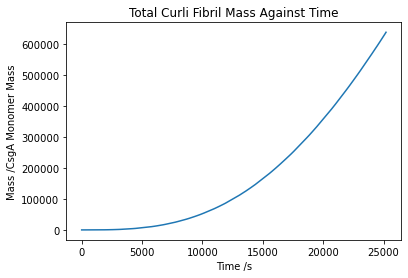

In [4]:
def simulate_fibrilation(total_time, ka):
    n_time_steps = int(total_time / TIME_STEP_LENGTH)
    qfg = QFGStatic(ka, TIME_STEP_LENGTH)
    
    model = UniformFibrilFormation(MAX_DISTANCE, N_XSTEPS, TIME_STEP_LENGTH, inhibitors=[qfg], 
                                   cBacteria=C_BACTERIA)

    total_mass_list = []
    time_list = []
    print(f'Running {n_time_steps} timesteps of {TIME_STEP_LENGTH} s')
    for t in range(n_time_steps):
        model.timeStep()
        total_mass_list.append(model.getMass())
        time_list.append(model.getTime())
    return model, time_list, total_mass_list

_, time_list, total_mass_list = simulate_fibrilation(TOTAL_TIME, 0)
plt.plot(time_list, total_mass_list)
plt.title('Total Curli Fibril Mass Against Time')
plt.xlabel('Time /s')
plt.ylabel('Mass /CsgA Monomer Mass')

We now have a model for fibril mass as a function of time. Let's call it $M(t,K_a)$, where $t$ is the time and K_a is the association constant. 

In the previously referenced paper, they detected a 30 % mass reduction after 5-7 hours incubation. We will therefore fit the parameter $K_a$ to $M(t,K_a) = 0.7M(t,0) $ with $|\frac{M(t,K_a)}{0.7M(t,0)} - 1| \leq 0.05$. 

We will perform the optimization for three differnt fibrillation times ($t_1 = 5h$, $t_1 = 6h$, $t_3=7h$) to properly include the incubation span. We are going to use the geometric mean in the binary search since the parameter space spanns several orders of magnitude. 

KA = 1.0
Running 36000 timesteps of 0.5 s
Finished in 46.684563875198364s, Total mass: 76302, error: 0.5972716529427692

KA = 0.1
Running 36000 timesteps of 0.5 s
Finished in 51.20525407791138s, Total mass: 225285, error: 0.18907309987665122

KA = 0.31622776601683794
Running 36000 timesteps of 0.5 s
Finished in 49.50307083129883s, Total mass: 160274, error: 0.15406040344616634

KA = 0.1778279410038923
Running 36000 timesteps of 0.5 s
Finished in 53.401204109191895s, Total mass: 197875, error: 0.04440082401443668

##################DONE#############
KA = 0.1778279410038923
Error: 0.04440082401443668
T = 5 h done in 201.29716992378235s 



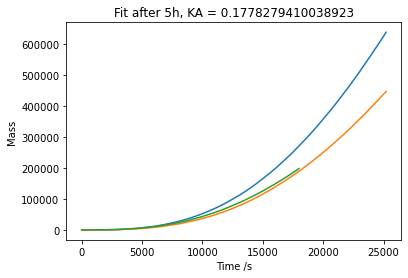

KA = 1.0
Running 43200 timesteps of 0.5 s
Finished in 54.79525017738342s, Total mass: 110711, error: 0.6366317568044364

KA = 0.1
Running 43200 timesteps of 0.5 s
Finished in 52.63418436050415s, Total mass: 352164, error: 0.1558491387190295

KA = 0.31622776601683794
Running 43200 timesteps of 0.5 s
Finished in 49.7753221988678s, Total mass: 240282, error: 0.21136248239545818

KA = 0.1778279410038923
Running 43200 timesteps of 0.5 s
Finished in 46.34688067436218s, Total mass: 304154, error: 0.0017260738237079298

##################DONE#############
KA = 0.1778279410038923
Error: 0.0017260738237079298
T = 6 h done in 204.381737947464s 



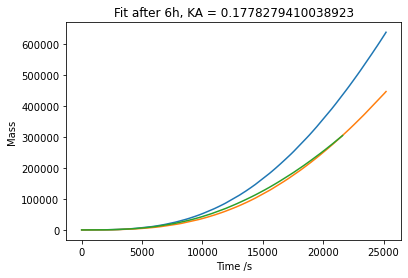

KA = 1.0
Running 50400 timesteps of 0.5 s
Finished in 62.9832968711853s, Total mass: 148611, error: 0.6669509849094694

KA = 0.1
Running 50400 timesteps of 0.5 s
Finished in 51.97779440879822s, Total mass: 502974, error: 0.12720454956998184

KA = 0.31622776601683794
Running 50400 timesteps of 0.5 s
Finished in 55.343687534332275s, Total mass: 333804, error: 0.25191881197704413

KA = 0.1778279410038923
Running 50400 timesteps of 0.5 s
Finished in 53.26926589012146s, Total mass: 428393, error: 0.0399373752839447

##################DONE#############
KA = 0.1778279410038923
Error: 0.0399373752839447
T = 7 h done in 224.44512248039246s 



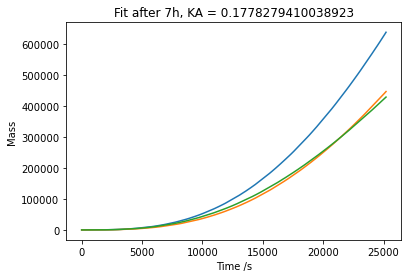

Fitted KA: [0.1778279410038923, 0.1778279410038923, 0.1778279410038923]
Averge KA: 0.1778279410038923, std = 0.0


In [5]:
from time import time
total_mass_after = {5 : total_mass_list[int(5*3600 / TIME_STEP_LENGTH)], 6:total_mass_list[int(6*3600 / TIME_STEP_LENGTH)],
                    7 : total_mass_list[-1]}

def binary_search_KA(t, true_mass, lower_bound=1e-2, upper_bound=1e2):
    max_iter = 10
    while max_iter > 0:
        timer1 = time()
        KA = np.sqrt(upper_bound*lower_bound)
        print(f'KA = {KA}')
        _, time_list, total_mass_list = simulate_fibrilation(t, KA)
        estimated_mass = total_mass_list[-1]

        if estimated_mass >= true_mass:
            lower_bound = KA
        else:
            upper_bound = KA
        max_iter -= 1
        print(f'Finished in {time() - timer1}s, Total mass: {estimated_mass}, error: {abs(estimated_mass /true_mass -1)}\n')
        if abs(estimated_mass / true_mass - 1) < 0.05:
            print('##################DONE#############')
            print(f'KA = {KA}')
            print(f'Error: {abs(estimated_mass / true_mass - 1)}')
            break
        
    return KA, time_list, total_mass_list
    
all_fitted_KA = []
for total_time in [5,6,7]:
    timer = time()
    true_mass = total_mass_after[total_time] * 0.7
    KA, time_list_fitted, total_mass_list_fitted = binary_search_KA(total_time*3600, true_mass)
    all_fitted_KA.append(KA)
    print(f'T = {total_time} h done in {time() - timer}s \n')
    plt.plot(time_list, total_mass_list, label='Uninhibited')
    plt.plot(time_list, [0.7*x for x in total_mass_list], label='70% of Uninhibited')
    plt.plot(time_list_fitted, total_mass_list_fitted, label='Fit')
    plt.xlabel('Time /s')
    plt.ylabel('Mass')
    plt.title(f'Fit after {total_time}h, KA = {KA}')
    plt.show()

print(f"Fitted KA: {all_fitted_KA}")
print(f'Averge KA: {np.mean(all_fitted_KA)}, std = {np.std(all_fitted_KA)}')
    
    

In [6]:
KA = np.mean(all_fitted_KA)
display(Latex(f'$K_a = {KA} /mols$'))

<IPython.core.display.Latex object>